In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression, make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn import preprocessing

from multiprocessing import Pool
from functools import partial

from CrossValidation import *
from FeatureSimilarity import GetTopGenes
from MatrixFactorization import CreateLatentVariables, FactorizeMatrix, GetRepresentationError

from utils import *

In [2]:
n = 100
g = 1000
o = 100
k = 20
genesImpactingPhenotype = 5

In [3]:
def GenerateDataset(n=100, g=1000, o=1, k=20, genesImpactingPhenotype=5):
    X_cls, y_cls = make_classification(n_samples=g, n_features=n, n_informative=20, n_redundant=20,
                                       n_repeated=0, n_classes=k, n_clusters_per_class=1, weights=None, 
                                       flip_y=0.01, class_sep=3.0, hypercube=True, shift=0.0, scale=0.3, 
                                       shuffle=True, random_state=None)
    X_cls = X_cls.T
    binaryPathwayMatrix = np.zeros((g, k))
    binaryPathwayMatrix[np.arange(g), y_cls] = 1
    Y, geneCoeffs = GenerateRegressedPhenotype(X_cls, numPhenotypes=o, lam=genesImpactingPhenotype, binaryPathwayMatrix=binaryPathwayMatrix, coeffSigma=0.5)
    X = np.concatenate([Y, X_cls], axis=1)
    neighbors = GetNeighborDictionary(binaryPathwayMatrix)
    return X, binaryPathwayMatrix, geneCoeffs

def DatasetToDF(X, binaryPathwayMatrix, geneCoeffs):
    y_cls = np.where(binaryPathwayMatrix > 0)[1]
    
    df = pd.DataFrame(X.T)
    is_gene = np.ones(g + o)
    is_gene[0:o] = 0
    gene_group = np.append(np.full(o, np.nan), y_cls)
    gene_coeff = np.append(np.full(o, np.nan), geneCoeffs)
    df['is_gene'] = is_gene
    df['gene_group'] = gene_group
    df = pd.concat([df, pd.DataFrame(np.concatenate([np.eye(o), geneCoeffs]), columns=['coeff{}'.format(i) for i in range(o)])], axis=1)
    return df

def DFtoDataset(df, scale=False):
    X = df[np.arange(n)].values.T
    if (scale):
        X = preprocessing.scale(X)
    y_cls = df['gene_group'].values[o:].astype(np.int32)
    binaryPathwayMatrix = np.zeros((g, k))
    binaryPathwayMatrix[np.arange(g), y_cls] = 1
    geneCoeffs = df[['coeff{}'.format(i) for i in range(o)]].values[o:, :]  

    return X, binaryPathwayMatrix, geneCoeffs

In [38]:
X, binaryPathwayMatrix, geneCoeffs = GenerateDataset(n=n, g=g, o=o, k=k, genesImpactingPhenotype=genesImpactingPhenotype)
df = DatasetToDF(X, binaryPathwayMatrix, geneCoeffs)
X_rec, binaryPathwayMatrix_rec, geneCoeffs_rec = DFtoDataset(df)
assert np.all(X == X_rec)
assert np.all(binaryPathwayMatrix == binaryPathwayMatrix_rec)
assert np.all(geneCoeffs == geneCoeffs_rec)

In [39]:
genes = X[:, o:]

In [68]:
pca = PCA(n_components=50)
projectedX = pca.fit_transform(X.T)
latent_dim = np.min(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0])
latent_dim

9

In [69]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsneProjectedX = tsne.fit_transform(projectedX)
df2 = pd.DataFrame({
    'tsne1': tsneProjectedX[:, 0],
    'tsne2': tsneProjectedX[:, 1],
    'pathway': ['phenotype'] * 100 + ['p{}'.format(i) for i in np.where(binaryPathwayMatrix > 0)[1]]
})

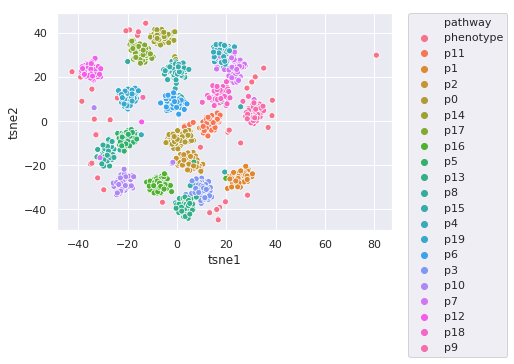

In [70]:
sns.scatterplot(x='tsne1', y='tsne2', hue='pathway', data=df2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [71]:
X_scaled = preprocessing.scale(X)

In [108]:
np.log(X_scaled + np.abs(np.min(X_scaled)) + 1)

array([[1.93263163, 1.96631538, 1.98934516, ..., 1.87983453, 1.9501422 ,
        1.98651814],
       [1.92581735, 1.96955902, 1.98091363, ..., 1.95031136, 1.94611225,
        1.96285366],
       [1.92476455, 1.97239975, 1.98692048, ..., 1.93182879, 1.93316607,
        1.98818587],
       ...,
       [2.05554656, 1.82928799, 1.86893498, ..., 2.15535956, 1.8809672 ,
        1.87002275],
       [1.93182905, 1.99116354, 1.9763153 , ..., 1.8791987 , 1.98798301,
        1.97539878],
       [1.922544  , 1.96232237, 1.97930573, ..., 1.95985486, 1.92019423,
        1.94382626]])

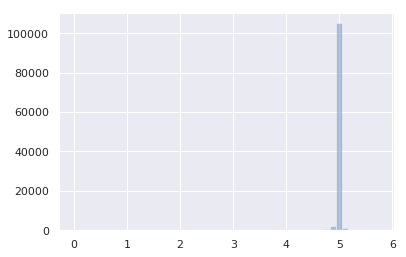

In [111]:
sns.distplot(np.log(X + np.abs(np.min(X)) + 1).flatten(), kde=False)

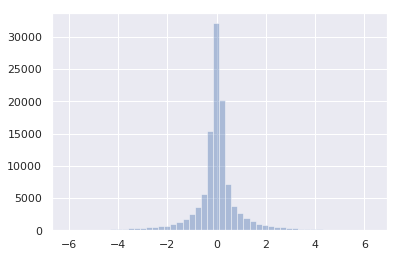

In [100]:
sns.distplot(X_scaled.flatten(), kde=False)

In [72]:
eta, lamb1, lamb2 = 0.077008, 0.011143, 0.001842
neighbors = GetNeighborDictionary(binaryPathwayMatrix)
U_pred_init, V_pred_init = CreateLatentVariables(n, g+o, 50)
U_pred, V_pred           = FactorizeMatrix(X_scaled, U_pred_init, V_pred_init, neighbors, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=10)

In [73]:
V_pred

array([[-0.15722191, -0.34474808, -0.42901272, ...,  0.13194227,
        -0.34678337, -0.23328443],
       [-0.03460137, -0.19462074,  0.29633528, ...,  0.31512138,
         0.18528652,  0.43743747],
       [ 0.30569428, -0.15220965,  0.4103228 , ..., -0.44582576,
         0.4573934 , -0.52636415],
       ...,
       [-0.1438795 , -0.10472033, -0.25822705, ..., -0.12374855,
         0.1164092 , -0.06114671],
       [-0.12901981,  0.08361746, -0.23588055, ..., -0.22962195,
         0.04364304, -0.08179136],
       [-0.46745053, -0.05221357,  0.36116725, ...,  0.45005572,
        -0.01230724,  0.30682164]], dtype=float32)

In [74]:
tsne_mf = TSNE(n_components=2)
tsneProjectedV = tsne.fit_transform(V_pred)
df3 = pd.DataFrame({
    'tsne1': tsneProjectedV[:, 0],
    'tsne2': tsneProjectedV[:, 1],
    'pathway': ['phenotype'] * 100 + ['p{}'.format(i) for i in np.where(binaryPathwayMatrix > 0)[1]]
})

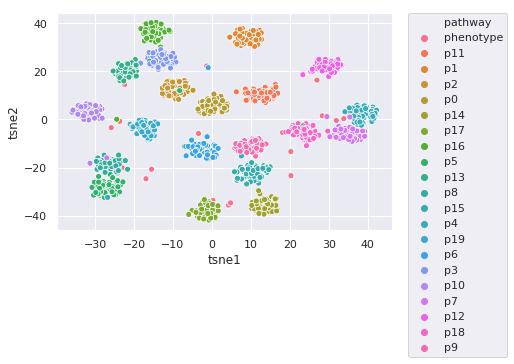

In [75]:
sns.scatterplot(x='tsne1', y='tsne2', hue='pathway', data=df3)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [79]:
genesDrivingPhenotype = np.where(geneCoeffs[:, 0] != 0)[0]

In [82]:
tg     = GetTopGenes(V_pred, 0, np.arange(o, g+o))
intersection_mat = np.zeros(g)
for i in range(g):
    intersection_mat[i] = np.sum(np.in1d(tg[i:i+1], genesDrivingPhenotype))

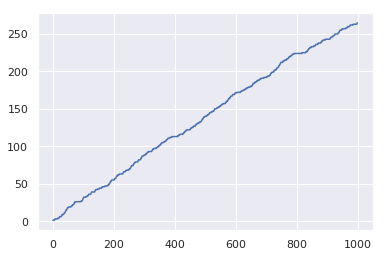

In [84]:
sns.lineplot(x=np.arange(g), y=np.cumsum(intersection_mat))

In [112]:
eta, lamb1, lamb2 = 0.077008, 0.011143, 0.001842
neighbors = GetNeighborDictionary(binaryPathwayMatrix)
U_pred_init, V_pred_init = CreateLatentVariables(n, g+o, 50)
U_pred, V_pred           = FactorizeMatrix(np.log(X + np.abs(np.min(X)) + 1), U_pred_init, V_pred_init, neighbors, 
                                     eta=eta, lamb1=lamb1, lamb2=lamb2, num_epochs=10)

In [113]:
V_pred

array([[ 0.2594231 , -0.15802163, -0.33366963, ..., -0.21782172,
        -0.0336015 ,  0.12888387],
       [ 0.30112112, -0.1313754 , -0.25661334, ..., -0.19929817,
        -0.03876498,  0.11352072],
       [ 0.38759375, -0.14105834, -0.250335  , ..., -0.18745828,
        -0.07422159,  0.10517203],
       ...,
       [ 0.3376765 , -0.15953441, -0.32244027, ..., -0.2254646 ,
        -0.05047604,  0.14301474],
       [ 0.31588233, -0.20807934, -0.27543133, ..., -0.19177167,
        -0.06427909,  0.07182087],
       [ 0.27447635, -0.1648667 , -0.30724457, ..., -0.19427142,
        -0.06397863,  0.07123835]], dtype=float32)

In [114]:
tg     = GetTopGenes(V_pred, 0, np.arange(o, g+o))
intersection_mat = np.zeros(g)
for i in range(g):
    intersection_mat[i] = np.sum(np.in1d(tg[i:i+1], genesDrivingPhenotype))

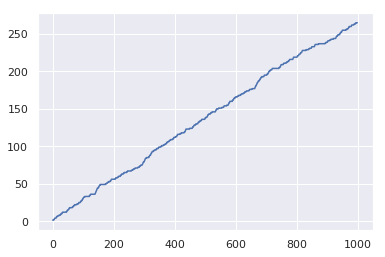

In [115]:
sns.lineplot(x=np.arange(g), y=np.cumsum(intersection_mat))

In [59]:
denom = 0
num = 0
for i in range(g - 1):
    for j in range(i + 1, g):
        num += np.linalg.norm(genes[:, i] - genes[:, j])
        denom += 1
print('Average point distance: {}'.format(num/denom))

Average point distance: 20.681089905987783


In [60]:
within_cluster_dist = 0
for l in range(k):
    ind = np.where(binaryPathwayMatrix[:, l] == 1)[0]
    genesInPath = genes[:, ind]
    denom = 0
    num = 0
    for i in range(len(ind) - 1):
        for j in range(i + 1, len(ind)):
            num += np.linalg.norm(genesInPath[:, i] - genesInPath[:, j])
            denom += 1
    within_cluster_dist += (num / denom)
print("Within cluster avg point dist: {}".format(within_cluster_dist / k))

Within cluster avg point dist: 13.811350212926726


In [61]:
print("Genes relevant to the first phenotype:")
print(np.where(geneCoeffs[:, 0] != 0)[0])

Genes relevant to the first phenotype:
[ 11  13  15  16  17  18  19  20  21  23  26  31  32  33  34  36  41  43
  45  46  48  50  53  57  58  64  71  73  74  76  77  78  87  88  89  93
  94  99 100 105 109 112 114 115 117 118 120 121 125 127 136 137 141 142
 145 146 150 152 156 157 161 165 166 170 171 172 176 182 186 187 192 196
 197 200 201 202 205 208 209 210 212 214 215 216 217 219 220 226 230 231
 238 240 243 249 255 256 258 261 272 274 275 277 278 282 286 289 290 291
 297 299 302 303 304 305 306 309 311 312 314 315 318 320 321 322 325 329
 332 334 342 343 345 350 352 353 355 356 357 358 366 369 372 373 374 375
 381 382 386 388 391 393 394 403 404 406 411 412 413 414 415 418 419 420
 422 423 425 426 427 429 430 433 436 437 438 439 442 443 446 448 452 459
 461 463 466 470 473 474 476 478 479 480 481 483 484 486 490 491 492 497
 498 499 500 501 502 505 513 515 516 517 519 521 523 528 531 532 538 539
 541 542 546 556 558 560 562 565 567 571 572 574 577 578 579 584 585 591
 594 595 599

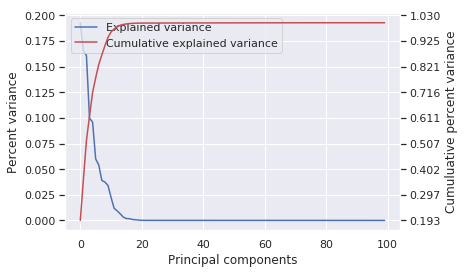

In [62]:
ScreePlot(X.T)

In [63]:
for i in range(100):
    X, binaryPathwayMatrix, geneCoeffs = GenerateDataset(n=n, g=g, o=o, k=k, genesImpactingPhenotype=genesImpactingPhenotype)
    df = DatasetToDF(X, binaryPathwayMatrix, geneCoeffs)
    df.to_csv('/homes/gws/psturm/simulatedData/regressionData/df{}.csv'.format(i), index=False)